  0%|          | 0/240 [00:00<?, ?it/s]

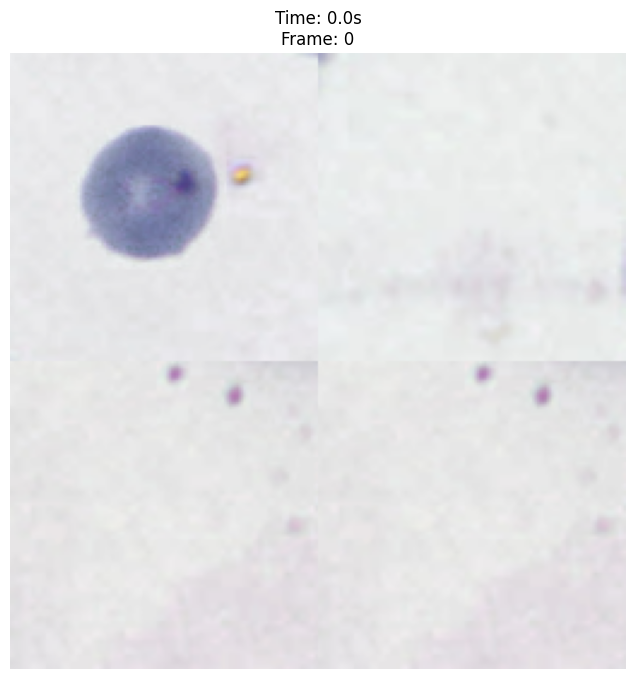

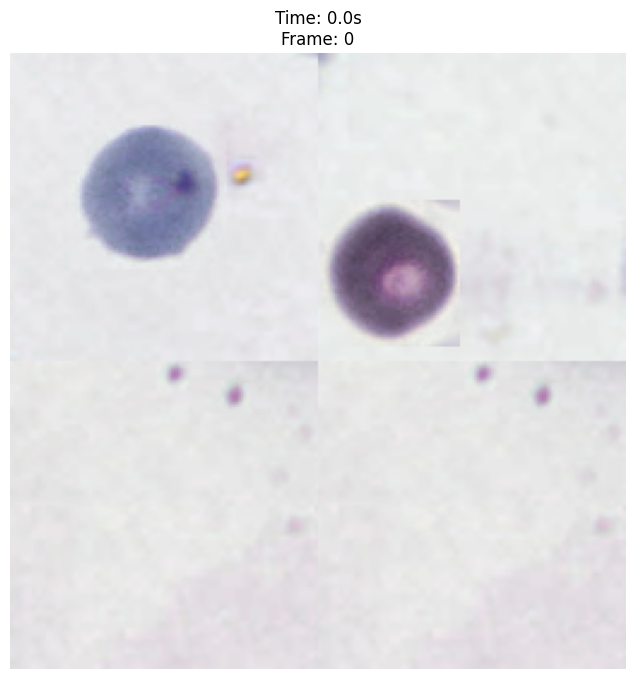

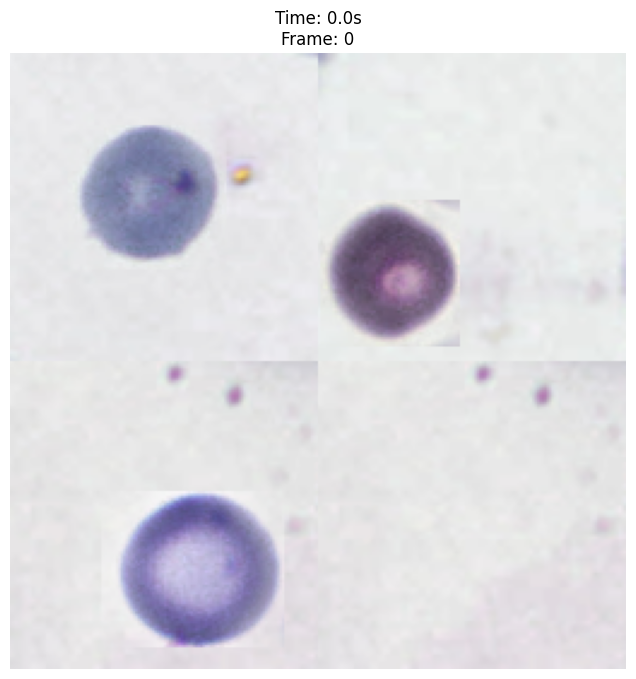

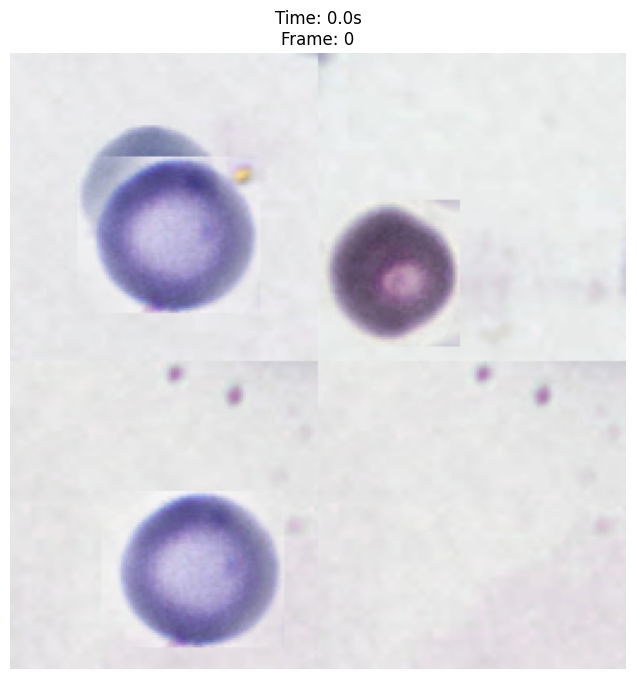

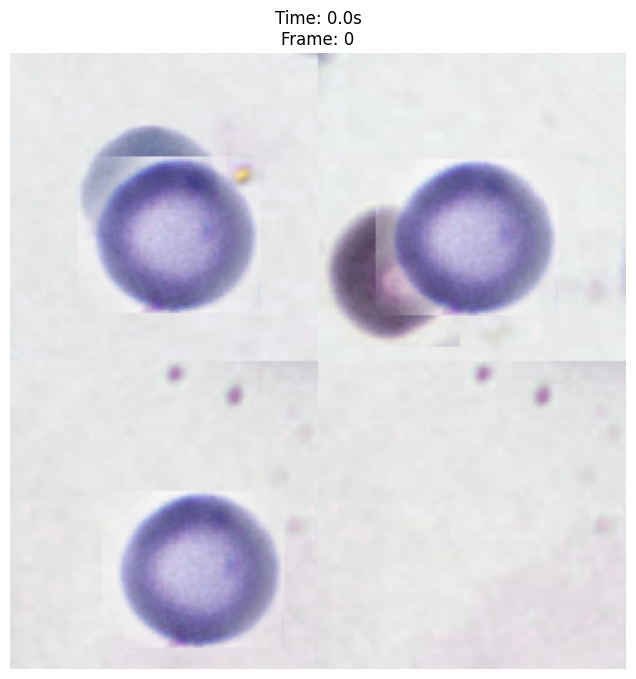

 18%|█▊        | 44/240 [00:02<00:05, 37.96it/s]

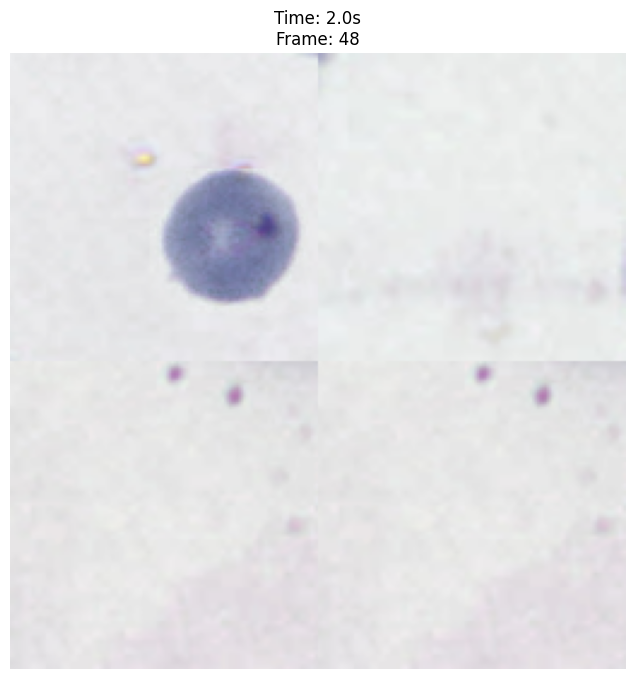

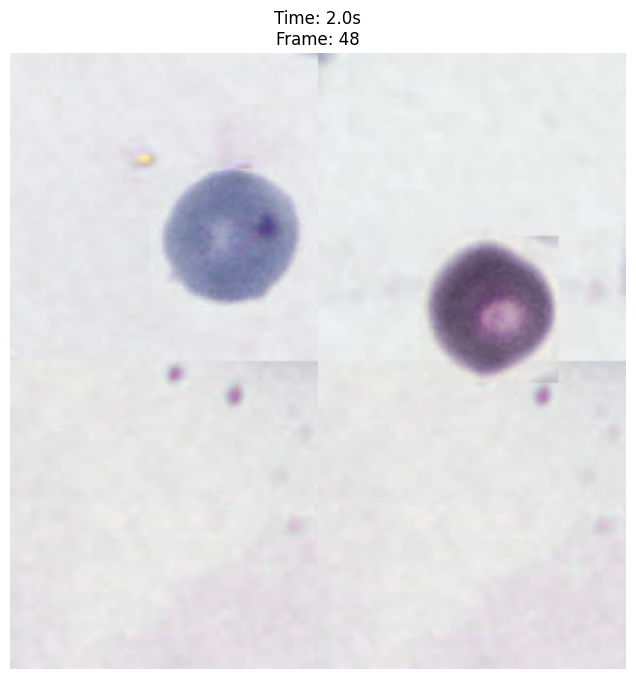

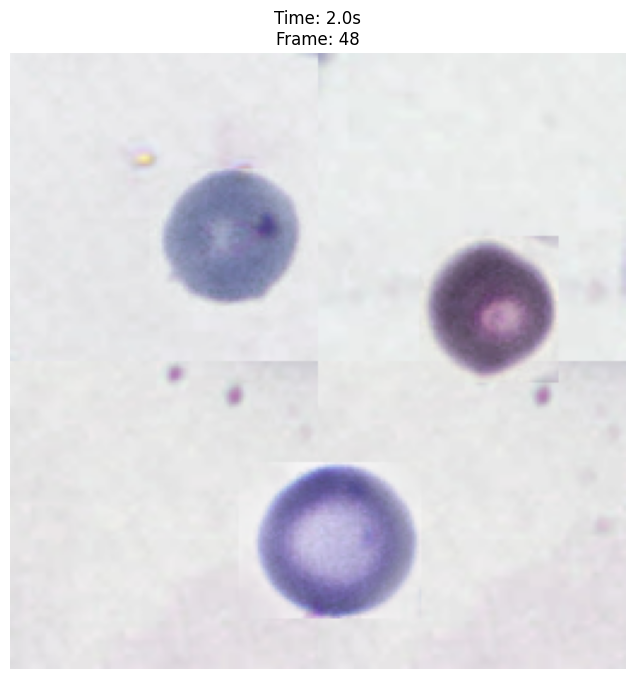

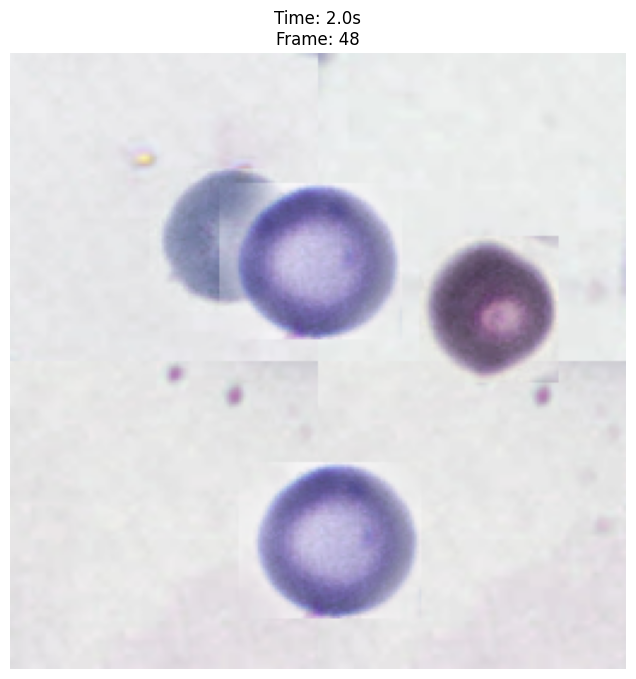

 36%|███▌      | 86/240 [00:03<00:04, 34.67it/s]

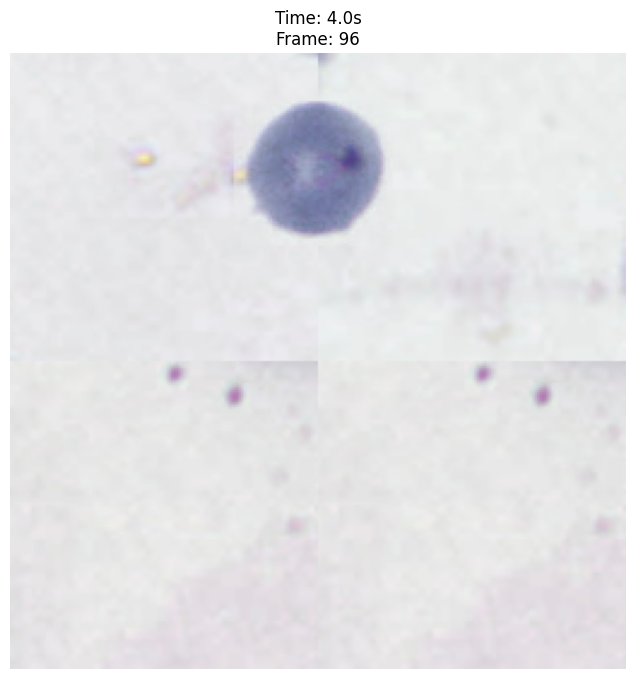

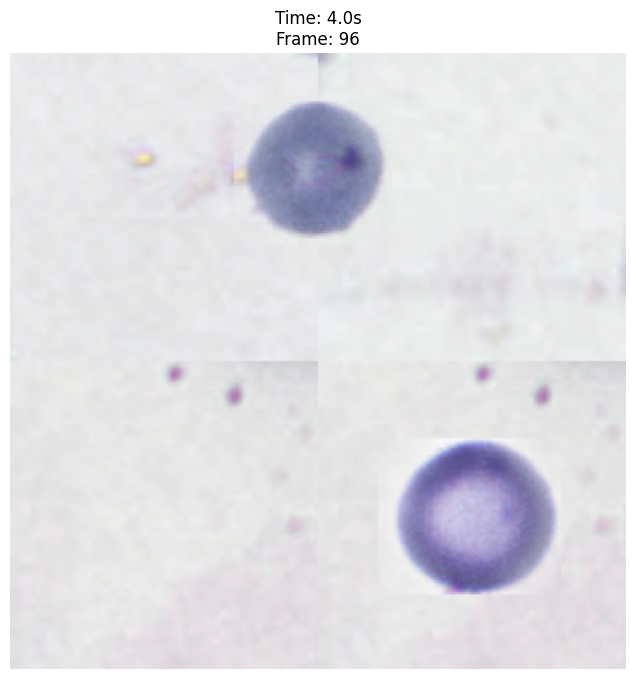

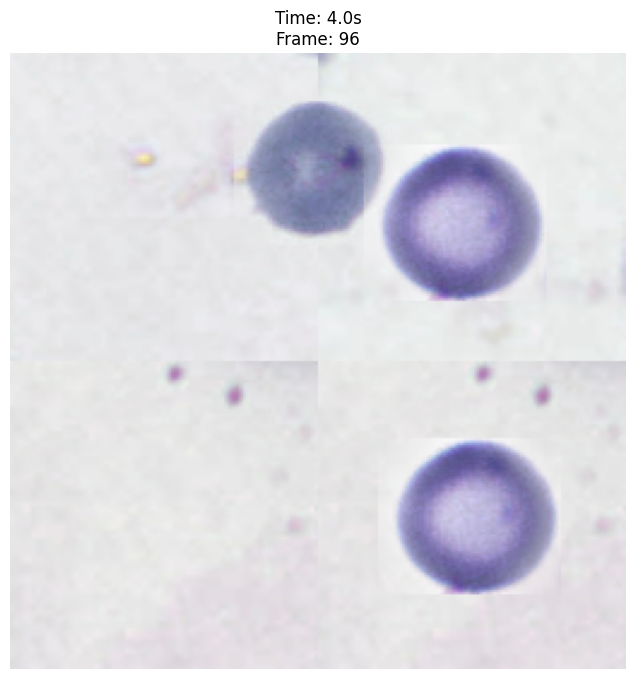

 49%|████▉     | 117/240 [00:05<00:03, 31.61it/s]

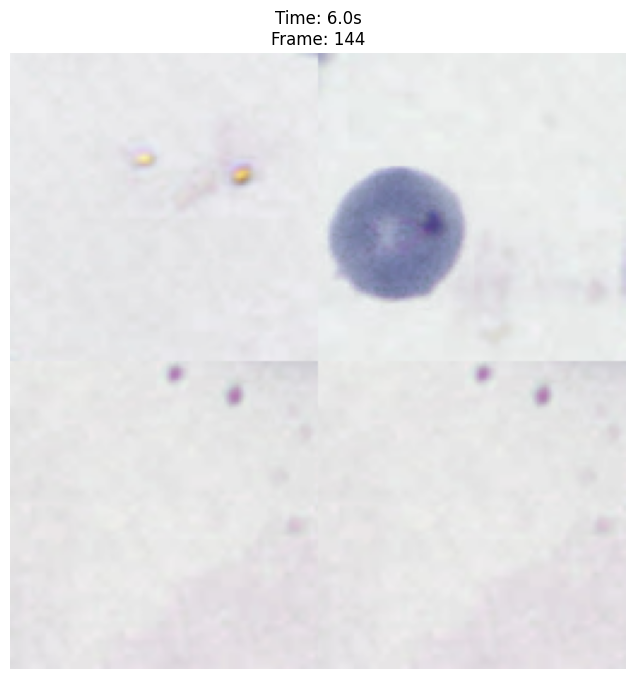

 60%|██████    | 145/240 [00:05<00:02, 42.20it/s]

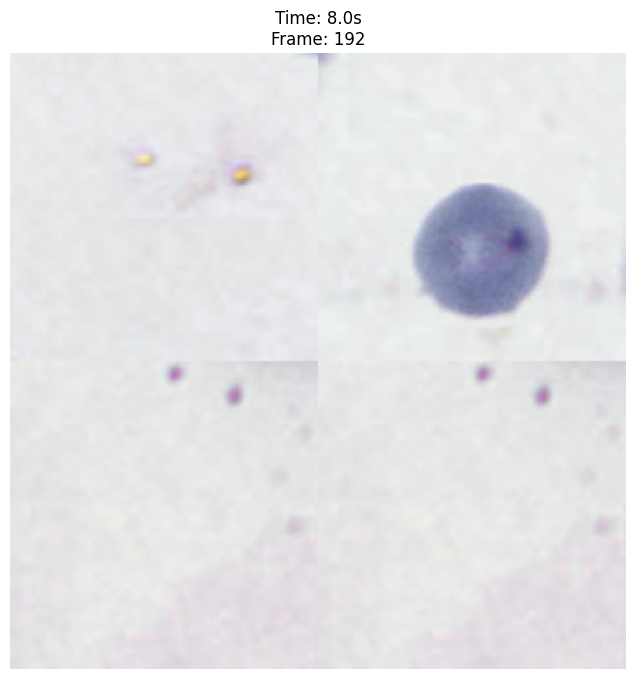

100%|██████████| 240/240 [00:06<00:00, 39.59it/s]


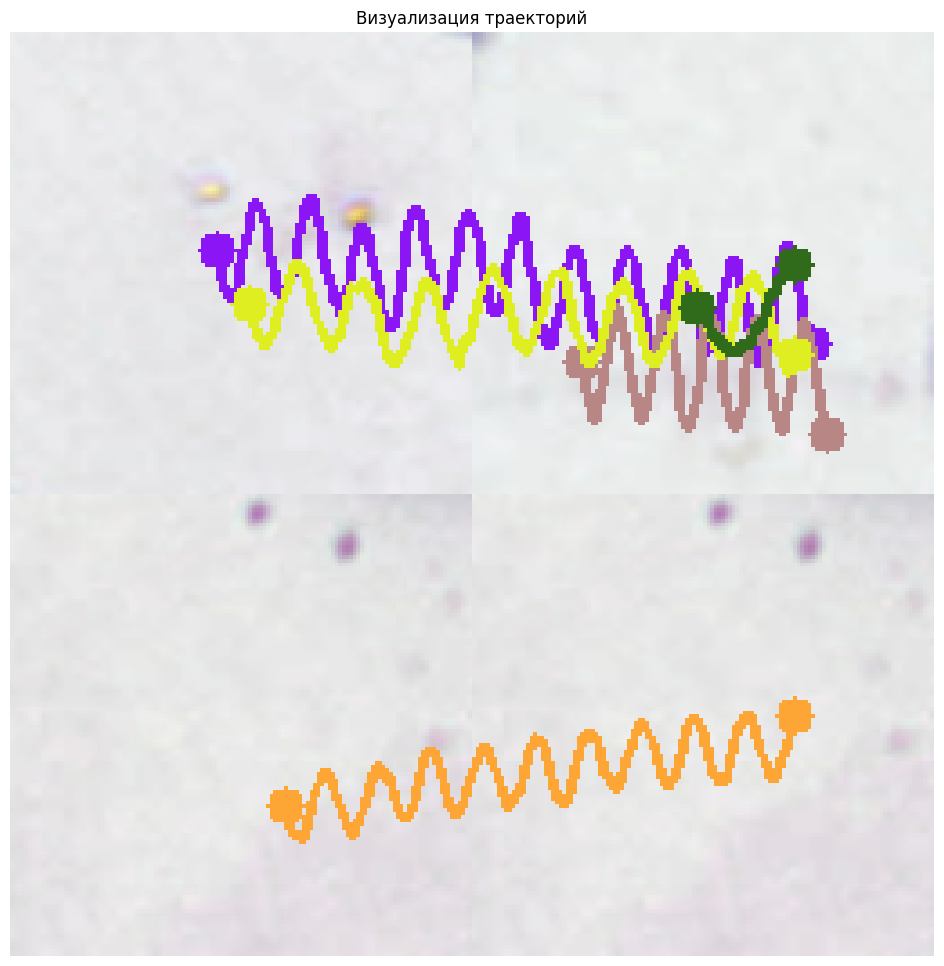

In [8]:
import cv2
import numpy as np
import random
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm

def load_patches_from_folder(folder_path):
    patches = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                patches.append(img)
    return patches

def generate_background_from_patches(background_patches, num_patches=8, output_size=(256, 256)):
    selected_patches = random.choices(background_patches, k=num_patches)
    background = np.zeros((output_size[0], output_size[1], 3), dtype=np.uint8)
    patch_size = 128

    for i in range(0, output_size[0], patch_size):
        for j in range(0, output_size[1], patch_size):
            if selected_patches:
                patch = selected_patches.pop()
                if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                    patch = cv2.resize(patch, (patch_size, patch_size))
                try:
                    background[i:i+patch_size, j:j+patch_size] = patch
                except:
                    pass
    return background

def overlay_cell_on_background(background, cell, x_center, y_center):
    h, w = cell.shape[:2]
    x = int(x_center - w // 2)
    y = int(y_center - h // 2)
    
    if x < 0 or y < 0 or x + w > background.shape[1] or y + h > background.shape[0]:
        return background
    
    output = background.copy()
    mask = np.zeros((h, w, 3), dtype=np.uint8)
    radius = min(h, w) // 2
    cv2.circle(mask, (w//2, h//2), radius, (255, 255, 255), -1)
    mask = cv2.GaussianBlur(mask, (51, 51), 0)
    mask = mask.astype(np.float32) / 255.0
    
    for c in range(3):
        output[y:y+h, x:x+w, c] = (
            output[y:y+h, x:x+w, c] * (1 - mask[:, :, c]) +
            cell[:, :, c] * mask[:, :, c]
        )
    return output


os.makedirs('debug_frames', exist_ok=True)

width, height = 256, 256
fps = 24
duration = 10
total_frames = fps * duration
num_cells = 5
save_interval = 2

patches_folder = 'content/patches'
background_patches = load_patches_from_folder(os.path.join(patches_folder, 'background'))
cell_patches = load_patches_from_folder(os.path.join(patches_folder, 'cells'))

static_background = generate_background_from_patches(background_patches)

with open('trajectories.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['frame', 'time', 'cell_id', 'x', 'y'])

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, fps, (width, height))

trajectories = []
colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(num_cells)]

cells = []
for cell_id in range(num_cells):
    cell = random.choice(cell_patches)
    h_cell, w_cell = cell.shape[:2]
    x0 = random.uniform(w_cell/2, width - w_cell/2)
    y0 = random.uniform(h_cell/2, height - h_cell/2)
    a = random.uniform(-0.1, 0.1)
    c = random.uniform(5, 20)
    omega = random.uniform(0.1, 0.5)
    delta_x = random.uniform(10, 30)
    eps_noise = [random.uniform(-5, 5) for _ in range(10)]
    
    cells.append({
        'id': cell_id,
        'cell': cell,
        'x0': x0,
        'y0': y0,
        'a': a,
        'c': c,
        'omega': omega,
        'delta_x': delta_x,
        'eps_noise': eps_noise,
        'active': True,
        'positions': []
    })
    trajectories.append({
        'id': cell_id,
        'color': colors[cell_id],
        'positions': []
    })

for frame_idx in tqdm(range(total_frames)):
    current_time = frame_idx / fps
    frame = static_background.copy()
    
    frame_data = []

    for cell_data in cells:
        if not cell_data['active']:
            continue
        
        cell = cell_data['cell']
        cell_id = cell_data['id']
        h_cell, w_cell = cell.shape[:2]
        
        # Расчет позиции
        x_center = cell_data['x0'] + cell_data['delta_x'] * current_time
        if x_center + w_cell/2 >= width:
            cell_data['active'] = False
            continue
        
        t_sec = int(current_time)
        if t_sec >= 10:
            cell_data['active'] = False
            continue
            
        delta_x_time = x_center - cell_data['x0']
        y_center = (cell_data['y0'] + 
                   cell_data['a'] * delta_x_time + 
                   cell_data['c'] * np.sin(cell_data['omega'] * delta_x_time) + 
                   cell_data['eps_noise'][t_sec])
        
        # Сохранение позиции
        cell_data['positions'].append((frame_idx, x_center, y_center))
        trajectories[cell_id]['positions'].append((int(x_center), int(y_center)))

        frame_data.append([
            frame_idx,
            current_time,
            cell_data['id'],
            x_center,
            y_center
        ])
        
        # Отрисовка клетки
        frame = overlay_cell_on_background(frame, cell, x_center, y_center)

        with open('trajectories.csv', 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(frame_data)

        if frame_idx % (fps * save_interval) == 0:
            debug_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            plt.figure(figsize=(8, 8))
            plt.imshow(debug_frame)
            plt.title(f'Time: {current_time:.1f}s\nFrame: {frame_idx}')
            plt.axis('off')
            plt.savefig(f'debug_frames/frame_{frame_idx:04d}.png', bbox_inches='tight')
            plt.show(block=False)
            plt.pause(0.1)
            plt.close()

    out.write(frame)

out.release()

# Визуализация траекторий
trajectory_image = static_background.copy()

# Чтение данных из CSV и отрисовка
with open('trajectories.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    tracks = {}
    for row in reader:
        cell_id = int(row['cell_id'])
        x = float(row['x'])
        y = float(row['y'])
        
        if cell_id not in tracks:
            tracks[cell_id] = {
                'positions': [],
                'color': colors[cell_id]
            }
        tracks[cell_id]['positions'].append((int(x), int(y)))

for cell_id, track in tracks.items():
    points = np.array(track['positions'], dtype=np.int32)
    if len(points) < 2:
        continue
    
    cv2.polylines(trajectory_image, [points], False, track['color'], 2)
    cv2.circle(trajectory_image, tuple(points[0]), 5, track['color'], -1)
    cv2.circle(trajectory_image, tuple(points[-1]), 5, track['color'], -1)

# Сохраняем и показываем итоговую визуализацию
cv2.imwrite('trajectories_visualization.png', trajectory_image)
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(trajectory_image, cv2.COLOR_BGR2RGB))
plt.title('Визуализация траекторий')
plt.axis('off')
plt.show()